# Week 7 HW - Vector Space Word Embeddings

In [2]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import spacy
import copy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths
import pickle

nlp = spacy.load('en')

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Exercise 1 -- word2vec 

Tasks:
- Try 2 `word2vec` specifications
- Visualize each of them with two viz techniques
- Arithmetic on words

In [126]:
with open('reddit_submissions_incels_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_incels, f)
    
with open('reddit_submissions_altright_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_altright, f)
    
with open('reddit_submissions_donald8_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_min8, f)   
    
with open('reddit_submissions_donald4_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_min4, f)  
    
with open('reddit_submissions_donald_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_trump, f)  
    
donald8_W2V.save("donald8_WORD2Vec")
donald4_W2V.save("donald4_WORD2Vec")
donald8_W2Vsoft.save("donald8_WORD2Vec_soft")
donald4_W2Vsoft.save("donald4_WORD2Vec_soft")

In [4]:
with open('reddit_submissions_donald8_tkns.pkl', 'rb') as f:
    reddit_submissions_min8 = pickle.load(f)
    
with open('reddit_submissions_donald4_tkns.pkl', 'rb') as f:
    reddit_submissions_min4 = pickle.load(f)

with open('reddit_submissions_altright_tkns.pkl', 'rb') as f:
    reddit_submissions_altright = pickle.load(f)
    
with open('reddit_submissions_incels_tkns.pkl', 'rb') as f:
    reddit_submissions_incels = pickle.load(f)

with open('reddit_submissions_donald_tkns.pkl', 'rb') as f:
    reddit_submissions_trump = pickle.load(f)
    

with open('donald8_WORD2Vec', 'rb') as f:
    donald8_W2V = pickle.load(f)
    
with open('donald4_WORD2Vec', 'rb') as f:
    donald4_W2V = pickle.load(f)
    
with open('donald8_WORD2Vec_soft', 'rb') as f:
    donald8_W2Vsoft = pickle.load(f)
    
with open('donald4_WORD2Vec_soft', 'rb') as f:
    donald4_W2Vsoft = pickle.load(f)

In [6]:
reddit_submissions_min= pandas.read_csv('../project_data/reddit_submissions_2015_18.csv', index_col=6)[['author', 'created_utc', 'subreddit', 'title', 'selftext', 'distinguished']]
reddit_submissions_min['created_datetime'] = pandas.to_datetime(reddit_submissions_min['created_utc'], unit='s')
reddit_submissions_min['created_tranche'] = pandas.cut(reddit_submissions_min['created_utc'], bins = 20, labels = list(range(20)))

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [136]:
reddit_submissions_incels = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'Incels')]
reddit_submissions_incels['post_text'] = reddit_submissions_incels['title'] + " " + reddit_submissions_incels['selftext']
reddit_submissions_incels['tokenized_sents'] = reddit_submissions_incels['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_incels['normalized_sents'] = reddit_submissions_incels['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [142]:
reddit_submissions_min['subreddit'].value_counts()

The_Donald        48092
KotakuInAction    14834
Incels            12862
Conservative       1891
altright            899
Republican          327
Name: subreddit, dtype: int64

In [143]:
reddit_submissions_altright = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'altright')]
reddit_submissions_altright['post_text'] = reddit_submissions_altright['title'] + " " + reddit_submissions_altright['selftext']
reddit_submissions_altright['tokenized_sents'] = reddit_submissions_altright['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_altright['normalized_sents'] = reddit_submissions_altright['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [51]:
reddit_submissions_min8 = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'The_Donald') & 
                                                       (reddit_submissions_min['created_tranche'] == 8)]
reddit_submissions_min4 = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'The_Donald') & 
                                                       (reddit_submissions_min['created_tranche'] == 4)]

In [52]:
reddit_submissions_min8['post_text'] = reddit_submissions_min8['title'] + " " + reddit_submissions_min8['selftext']
reddit_submissions_min8['tokenized_sents'] = reddit_submissions_min8['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_min8['normalized_sents'] = reddit_submissions_min8['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

reddit_submissions_min4['post_text'] = reddit_submissions_min4['title'] + " " + reddit_submissions_min4['selftext']
reddit_submissions_min4['tokenized_sents'] = reddit_submissions_min4['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_min4['normalized_sents'] = reddit_submissions_min4['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [53]:
donald8_W2V = gensim.models.word2vec.Word2Vec(reddit_submissions_min8['normalized_sents'].sum())
donald4_W2V = gensim.models.word2vec.Word2Vec(reddit_submissions_min4['normalized_sents'].sum())

In [54]:
donald8_W2V.most_similar('liberal')

[('leave', 0.9967672824859619),
 ('scare', 0.996751070022583),
 ('black', 0.9965715408325195),
 ('tire', 0.9961039423942566),
 ('life', 0.9950675368309021),
 ('americans', 0.9948298931121826),
 ('stand', 0.9947570562362671),
 ('racist', 0.9942721724510193),
 ('understand', 0.9941738843917847),
 ('fight', 0.9935716390609741)]

In [55]:
donald4_W2V.most_similar('liberal')

[('male', 0.9716025590896606),
 ('shit', 0.9648157954216003),
 ('family', 0.9588555693626404),
 ('cis', 0.9580625295639038),
 ('art', 0.956328809261322),
 ('black', 0.9544196128845215),
 ('white', 0.951651930809021),
 ('life', 0.9513400793075562),
 ('girl', 0.9489227533340454),
 ('grow', 0.9488340616226196)]

In [33]:
donald4_W2V.most_similar('immigration')

[('immigrant', 0.9980612397193909),
 ('illegal', 0.984207034111023),
 ('border', 0.9784513711929321),
 ('american', 0.9715807437896729),
 ('alien', 0.9578444361686707),
 ('mexico', 0.9573886394500732),
 ('government', 0.9465535879135132),
 ('law', 0.9439253807067871),
 ('trade', 0.9404299259185791),
 ('wall', 0.9388926029205322)]

In [34]:
donald8_W2V.most_similar('immigration')

[('bear', 0.9997624158859253),
 ('division', 0.9996041059494019),
 ('protection', 0.9995772838592529),
 ('pull', 0.9995088577270508),
 ('intend', 0.9994912147521973),
 ('terrorism', 0.9994733333587646),
 ('son', 0.9994708299636841),
 ('healthcare', 0.9994666576385498),
 ('mistake', 0.999466061592102),
 ('ship', 0.9994590282440186)]

In [43]:
donald4_W2V.most_similar('foreign')

[('law', 0.993635892868042),
 ('u.s', 0.9925585985183716),
 ('undocumented', 0.9922058582305908),
 ('mexican', 0.9921127557754517),
 ('workforce', 0.9907346963882446),
 ('trade', 0.9903888702392578),
 ('health', 0.9903799295425415),
 ('refugee', 0.990288496017456),
 ('alien', 0.9899847507476807),
 ('rape', 0.9895515441894531)]

In [44]:
donald8_W2V.most_similar('foreign')

[('influence', 0.9978323578834534),
 ('congress', 0.9976338148117065),
 ('million', 0.9975787997245789),
 ('allow', 0.9973333477973938),
 ('supreme', 0.9970723390579224),
 ('illegal', 0.9969939589500427),
 ('refuse', 0.9968581795692444),
 ('close', 0.9967610836029053),
 ('exception', 0.9966164231300354),
 ('court', 0.9965746402740479)]

In [60]:
donald8_W2V.most_similar('democrat')

[('person', 0.9972376823425293),
 ('change', 0.9961291551589966),
 ('rig', 0.9946810007095337),
 ('republican', 0.9942684173583984),
 ('college', 0.9942322969436646),
 ('candidate', 0.9935974478721619),
 ('primary', 0.9930822849273682),
 ('chance', 0.9918277263641357),
 ('sander', 0.9912192821502686),
 ('lose', 0.9908117055892944)]

In [61]:
donald4_W2V.most_similar('democrat')

[('register', 0.9837706685066223),
 ('democratic', 0.9816001057624817),
 ('presidential', 0.9801721572875977),
 ('steal', 0.9671924710273743),
 ('general', 0.9667967557907104),
 ('establishment', 0.9663398861885071),
 ('lose', 0.9661449193954468),
 ('election', 0.963850736618042),
 ('republicans', 0.9634897708892822),
 ('independent', 0.9596998691558838)]

In [73]:
donald4_W2V.most_similar('mexican')

[('u.s', 0.9978862404823303),
 ('refugee', 0.9968644380569458),
 ('citizen', 0.9962786436080933),
 ('china', 0.995557427406311),
 ('islamic', 0.9953213334083557),
 ('system', 0.994718074798584),
 ('trade', 0.9943752884864807),
 ('workforce', 0.9938507080078125),
 ('exploit', 0.9937943816184998),
 ('undocumented', 0.9934136867523193)]

In [72]:
donald8_W2V.most_similar('mexican')

[('ideology', 0.9991565346717834),
 ('young', 0.9990911483764648),
 ('tear', 0.9990442395210266),
 ('sjw', 0.9988831281661987),
 ('ass', 0.9988289475440979),
 ('disgrace', 0.9988203048706055),
 ('jewish', 0.998818039894104),
 ('wall', 0.9988049864768982),
 ('smart', 0.9987630844116211),
 ('table', 0.9987449645996094)]

In [74]:
donald8_W2V.most_similar(positive=['mexican', 'clinton'],
                        negative = ['trump'])

[('john', 0.9441418051719666),
 ('/watch?v=_x16_kzx1ve', 0.92958664894104),
 ('release', 0.9286057949066162),
 ('fbi', 0.9279534816741943),
 ('leak', 0.9207971096038818),
 ('include', 0.9196463227272034),
 ('would', 0.9175896048545837),
 ('$', 0.915286660194397),
 ('server', 0.9102073907852173),
 ('dnc', 0.903327226638794)]

In [76]:
donald4_W2V.most_similar(positive=['mexican', 'clinton'])

[('give', 0.9919983148574829),
 ('corrupt', 0.9910762906074524),
 ('dnc', 0.9901973605155945),
 ('dem', 0.9894123673439026),
 ('disenfranchise', 0.9890768527984619),
 ('eventual', 0.9890520572662354),
 ('away', 0.9888917207717896),
 ('majority', 0.9886289238929749),
 ('cycle', 0.9883639812469482),
 ('senate', 0.9883153438568115)]

In [77]:
donald4_W2V.most_similar(positive=['mexican', 'trump'])

[('boost', 0.9826087951660156),
 ('twice', 0.982471227645874),
 ('seal', 0.9819692969322205),
 ('wi', 0.9817606806755066),
 ('single', 0.9815791249275208),
 ('tl;dr', 0.9812630414962769),
 ('anticipate', 0.9805881977081299),
 ('possibly', 0.9805836081504822),
 ('true', 0.9804460406303406),
 ('ohioans', 0.9803899526596069)]

In [89]:
donald8_W2V.most_similar('leftist')

[('fascist', 0.9996554851531982),
 ('bitch', 0.9996104836463928),
 ('tear', 0.9995861053466797),
 ('violent', 0.9995797276496887),
 ('trigger', 0.9995495676994324),
 ('despite', 0.9995408058166504),
 ('cucks', 0.9995261430740356),
 ('jewish', 0.9994940161705017),
 ('thanksgiving', 0.9994848370552063),
 ('lord', 0.9994644522666931)]

In [90]:
donald4_W2V.most_similar('leftist')

[('minor', 0.9980483651161194),
 ('paragraph', 0.9980237483978271),
 ('course', 0.9980102777481079),
 ('innocent', 0.9979696273803711),
 ('subject', 0.9977161288261414),
 ('agendum', 0.9976149797439575),
 ('disrupt', 0.9974727630615234),
 ('spin', 0.9974364042282104),
 ('charge', 0.997429370880127),
 ('boy', 0.9973781704902649)]

In [108]:
donald4_W2V.most_similar('news')

[('fox', 0.9715726375579834),
 ('report', 0.943863034248352),
 ('cnn', 0.9353094100952148),
 ('carly', 0.9350003004074097),
 ('scandal', 0.9348690509796143),
 ('national', 0.9188006520271301),
 ('|', 0.916765570640564),
 ('rule', 0.9153780937194824),
 ('pac', 0.9090359210968018),
 ('fund', 0.9084845781326294)]

In [109]:
donald8_W2V.most_similar('news')

[('fake', 0.958344578742981),
 ('source', 0.9509509205818176),
 ('video', 0.9501924514770508),
 ('twitter', 0.9485650658607483),
 ('article', 0.9461296796798706),
 ('specialist', 0.9417068958282471),
 ('compilation', 0.9410412311553955),
 ('tweet', 0.9401676058769226),
 ('obscure', 0.9395379424095154),
 ('pizza', 0.9386619925498962)]

In [118]:
donald8_W2V.most_similar('america')

[('country', 0.9601031541824341),
 ('want', 0.9358538389205933),
 ('make', 0.9235935807228088),
 ('great', 0.9232475161552429),
 ('well', 0.9201866388320923),
 ('love', 0.920025646686554),
 ('feel', 0.9188270568847656),
 ('people', 0.9188000559806824),
 ('way', 0.9133871793746948),
 ('good', 0.9114383459091187)]

In [119]:
donald4_W2V.most_similar('america')

[('country', 0.9098458886146545),
 ('objectively', 0.8831343650817871),
 ('make', 0.8768491148948669),
 ('want', 0.8319543600082397),
 ('world', 0.8229115009307861),
 ('nation', 0.8031808733940125),
 ('great', 0.7991867065429688),
 ('fervent', 0.7935578227043152),
 ('man', 0.7887927293777466),
 ('bless', 0.7801814675331116)]

In [124]:
donald8_W2V.most_similar('woman')

[('racist', 0.995869517326355),
 ('stand', 0.995624303817749),
 ('choice', 0.9955204129219055),
 ('corrupt', 0.9954726099967957),
 ('pro', 0.9951475858688354),
 ('policy', 0.9949957728385925),
 ('accept', 0.9948590993881226),
 ('courage', 0.9947192072868347),
 ('daddy', 0.9945763945579529),
 ('family', 0.994556725025177)]

In [123]:
donald4_W2V.most_similar('woman')

[('care', 0.9855266809463501),
 ('money', 0.9820683598518372),
 ('war', 0.9786428809165955),
 ('problem', 0.9776806831359863),
 ('europe', 0.9766192436218262),
 ('million', 0.9762384295463562),
 ('politician', 0.9738833904266357),
 ('black', 0.9736466407775879),
 ('political', 0.9725786447525024),
 ('isis', 0.9717080593109131)]

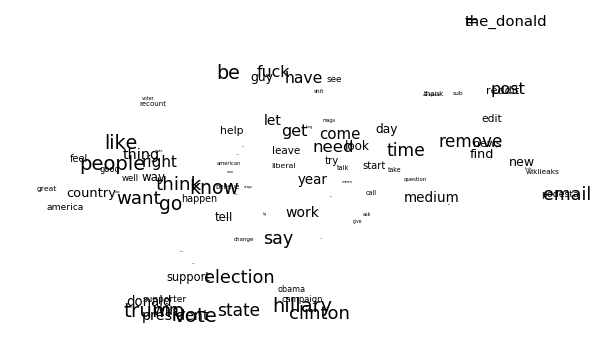

In [117]:
numWords = 100
targetWords_d8 = donald8_W2V.wv.index2word[:numWords]

wordsSubMatrix_d8 = []
for word in targetWords_d8:
    wordsSubMatrix_d8.append(donald8_W2V[word])
wordsSubMatrix_d8 = np.array(wordsSubMatrix_d8)

pcaWords_d8 = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix_d8)
reducedPCA_data_d8 = pcaWords.transform(wordsSubMatrix_d8)
#T-SNE is theoretically better, but you should experiment
tsneWords_d8 = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data_d8)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_d8[:, 0], tsneWords_d8[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords_d8[:, 0][i],tsneWords_d8[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

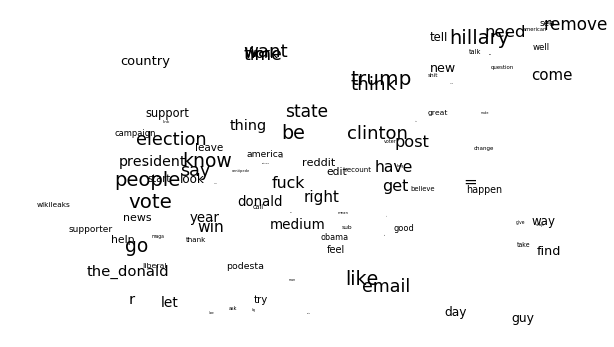

In [125]:
numWords = 100
targetWords_d4 = donald4_W2V.wv.index2word[:numWords]

wordsSubMatrix_d4 = []
for word in targetWords_d4:
    wordsSubMatrix_d4.append(donald4_W2V[word])
wordsSubMatrix_d4 = np.array(wordsSubMatrix_d4)

pcaWords_d4 = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix_d4)
reducedPCA_data_d4 = pcaWords.transform(wordsSubMatrix_d4)
#T-SNE is theoretically better, but you should experiment
tsneWords_d4 = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data_d4)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_d4[:, 0], tsneWords_d4[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords_d4[:, 0][i],tsneWords_d4[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

## Exercise 4 - Scores

In [130]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [133]:
donald8_W2Vsoft = gensim.models.word2vec.Word2Vec(reddit_submissions_min8['normalized_sents'].sum(), hs = 1, negative = 0)
donald4_W2Vsoft = gensim.models.word2vec.Word2Vec(reddit_submissions_min4['normalized_sents'].sum(), hs = 1, negative = 0)

In [137]:
reddit_submissions_incels['likelihood_d8'] = reddit_submissions_incels['normalized_sents'].apply(lambda x: adprob(x, donald8_W2Vsoft))
reddit_submissions_incels['likelihood_d4'] = reddit_submissions_incels['normalized_sents'].apply(lambda x: adprob(x, donald4_W2Vsoft))

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [140]:
for post in reddit_submissions_incels.sort_values(by = 'likelihood_d8', ascending = False)['post_text'][:10]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

Who are your favourite and least favourite incels my favourite: alia harkonnen

least favourite: gambler



---------------



#MeTooTeehee xD xD xD


---------------



REE REE REE REE REE! REEEEEEE


---------------



How virgin are you? I am a

1. Kissless
2. Hugless
3. Handholdless
4. Touchless
5. Dateless
6. Complimentless
7. Smileless
8. Phonecallless
9. Textless
10. Friendless

virgin.

EDIT: Added 5, 6, 7


---------------



If you have no jaw and or chin IT'S OVER It's FUCKING OVER FOR ME. I have a subhuman jaw and chin.


---------------



Men How Many Of These Attractive Traits Do You Have https://www.youtube.com/watch?v=EFnJMPQow7A
17:58-22:15




---------------



Chad. Are Chads exclusively white? Do they have to be muscular or...? What are their traits? 


---------------



What kind of -cel are you? I'm:

* Gymcel
* Suicel
* Acnecel
* Narcissist-cel


---------------



˙ʇı ןןɐɔ noʎ ɹǝʌǝʇɐɥʍ ɹo ,ɐʇǝq, pǝɹǝpısuoɔ buıǝq ɟo ʞɔıs ɯ,ı ˙ʇı ʇnoqɐ ʎɹɔ oʇ ǝɯ oʇ ʞןɐʇ ʎןuo pu

In [141]:
for post in reddit_submissions_incels.sort_values(by = 'likelihood_d4', ascending = False)['post_text'][:10]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

#MeTooTeehee xD xD xD


---------------



REE REE REE REE REE! REEEEEEE


---------------



How virgin are you? I am a

1. Kissless
2. Hugless
3. Handholdless
4. Touchless
5. Dateless
6. Complimentless
7. Smileless
8. Phonecallless
9. Textless
10. Friendless

virgin.

EDIT: Added 5, 6, 7


---------------



If you have no jaw and or chin IT'S OVER It's FUCKING OVER FOR ME. I have a subhuman jaw and chin.


---------------



What kind of -cel are you? I'm:

* Gymcel
* Suicel
* Acnecel
* Narcissist-cel


---------------



Fill in the blank It's all about the ___________ .


---------------



˙ʇı ןןɐɔ noʎ ɹǝʌǝʇɐɥʍ ɹo ,ɐʇǝq, pǝɹǝpısuoɔ buıǝq ɟo ʞɔıs ɯ,ı ˙ʇı ʇnoqɐ ʎɹɔ oʇ ǝɯ oʇ ʞןɐʇ ʎןuo puɐ ‘ʇıɥs ǝʞıן ɯǝɥʇ ʇɐǝɹʇ oɥʍ sʎnb bɐqǝɥɔnop ɹǝʇɟɐ ob sʎɐʍןɐ sןɹıb ǝsǝɥʇ puǝ ǝɥʇ uı ˙ʎpɐן,ɯ ɹoɟ buıɥʇʎuɐ op pןnoʍ puɐ ‘qoظ ǝɔıu ɐ ʞɹoʍ ‘ʎnb ǝɔıu ɐ ɯ,ı ˙ǝuoz puǝıɹɟ ǝɥʇ uı ʇnd buıǝq sʎɐʍןɐ ı ɯɐ ʎɥʍ only truecels can read this


---------------



I Have an STD and I'm a Virgin Genital wart. A virgin wit

In [144]:
reddit_submissions_altright['likelihood_d8'] = reddit_submissions_altright['normalized_sents'].apply(lambda x: adprob(x, donald8_W2Vsoft))
reddit_submissions_altright['likelihood_d4'] = reddit_submissions_altright['normalized_sents'].apply(lambda x: adprob(x, donald4_W2Vsoft))

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [145]:
for post in reddit_submissions_altright.sort_values(by = 'likelihood_d8', ascending = False)['post_text'][:10]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

Why is the Irish IQ so low? https://iq-research.info/en/page/average-iq-by-country/ie-ireland

90-92.

Are the Irish an impediment on us Anglos and Germanics?


---------------



Why even call yourselves alt-right? [removed]


---------------



Is anyone here a former SJW but now Alt-Right? Is anyone here a former SJW but now Alt-Right?  If so, how'd that occur?


---------------



What is so great about Homogenization? [removed]


---------------



Can we make a list of pundits, celebrities, etc. who changed their name to hide the fact that they are Jewish? Comments down below with be added:

(((Larry King))) - Lawrence Zeiger

(((Ayn Rand))) - Alisa Rosenbaum

(((Sumner Redstone))) - Sumner Rothstein

(((Woody Allen))) - Allen Konigsberg

(((Mel Brooks))) - Melvin Kaminsky

(((Bob Dylan))) - Robert Zimmerman

(((Rodney Dangerfield))) - Jacob Cohen

(((Jerry Lewis))) - Joseph Levitch

(((Joan Rlvers))) - Joan Molinsky

(((Jon Stewart))) - Jonathan Leibowitz


---------------



Wh

In [146]:
for post in reddit_submissions_altright.sort_values(by = 'likelihood_d4', ascending = False)['post_text'][:10]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

What does everyone think about Anders Breivik? [](https://i.guim.co.uk/img/static/sys-images/Guardian/Pix/pictures/2012/8/24/1345800207399/Anders-Behring-Breivik-sm-010.jpg?w=700&amp;q=55&amp;auto=format&amp;usm=12&amp;fit=max&amp;s=dc508ea668111d96a5826e57a0deec99)


---------------



Can we make a list of pundits, celebrities, etc. who changed their name to hide the fact that they are Jewish? Comments down below with be added:

(((Larry King))) - Lawrence Zeiger

(((Ayn Rand))) - Alisa Rosenbaum

(((Sumner Redstone))) - Sumner Rothstein

(((Woody Allen))) - Allen Konigsberg

(((Mel Brooks))) - Melvin Kaminsky

(((Bob Dylan))) - Robert Zimmerman

(((Rodney Dangerfield))) - Jacob Cohen

(((Jerry Lewis))) - Joseph Levitch

(((Joan Rlvers))) - Joan Molinsky

(((Jon Stewart))) - Jonathan Leibowitz


---------------



What is so great about Homogenization? [removed]


---------------



Is anyone here a former SJW but now Alt-Right? Is anyone here a former SJW but now Alt-Right?  If so, 

In [147]:
reddit_submissions_altright.head()

,author,created_utc,subreddit,title,selftext,distinguished,created_datetime,created_tranche,post_text,tokenized_sents,normalized_sents,likelihood_d8,likelihood_d4
id,,,,,,,,,,,,,
4dgf5j,avian_buddha,1459863156,altright,List of Alt Right Websites,Let's get a list going so that anybody can com...,moderator,2016-04-05 13:32:36,4,List of Alt Right Websites Let's get a list go...,"[[List, of, Alt], [Right, Websites, Let, 's, g...","[[list, alt], [right, website, let, list, go, ...",-10.893825,-11.331831
4rj06j,AugustJRush,1467818739,altright,What type of content do you guys like to see?,"Would you folk like to see more news stories, ...",NaN,2016-07-06 15:25:39,6,What type of content do you guys like to see? ...,"[[What, type, of, content, do, you, guys, like...","[[type, content, guy, like], [folk, like, news...",-40.145859,-42.458706
4s2m7h,LetThereBeWhite,1468103206,altright,"Damn, 250 subscribers to 450 in less than a we...",_____________\n\n-\n\n# For once in its cuck l...,moderator,2016-07-09 22:26:46,6,"Damn, 250 subscribers to 450 in less than a we...","[[Damn, 250, subscribers, to, 450, in, less, t...","[[damn, subscriber, week], [time], [time, red,...",-24.340067,-24.601299
4s39s6,AugustJRush,1468113131,altright,How do you describe your political leanings to...,"I usually just go with ""Far-Right"", which is g...",NaN,2016-07-10 01:12:11,6,How do you describe your political leanings to...,"[[How, do, you, describe, your, political, lea...","[[describe, political, leaning, normies], [usu...",-19.518883,-17.469717
4s63m0,YukonAurelius,1468167550,altright,Any interest in alt-right reading group?,"I was thinking of digging into Spengler's ""Dec...",NaN,2016-07-10 16:19:10,6,Any interest in alt-right reading group? I was...,"[[Any, interest, in, alt, right, reading, grou...","[[interest, alt, right, read, group], [think, ...",-41.660336,-43.229820


In [150]:
reddit_submissions_con['likelihood_d8'] = reddit_submissions_con['normalized_sents'].apply(lambda x: adprob(x, donald8_W2Vsoft))
reddit_submissions_con['likelihood_d4'] = reddit_submissions_con['normalized_sents'].apply(lambda x: adprob(x, donald4_W2Vsoft))

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [151]:
reddit_submissions_con.head()

,author,created_utc,subreddit,title,selftext,distinguished,created_datetime,created_tranche,post_text,tokenized_sents,normalized_sents,likelihood_d8,likelihood_d4
id,,,,,,,,,,,,,
39tbk2,nicksvr4,1434297481,Conservative,"TIL the US has greater purchasing power, and m...",[Greater purchasing power](https://en.wikipedi...,NaN,2015-06-14 15:58:01,0,"TIL the US has greater purchasing power, and m...","[[TIL, the, US, has, greater, purchasing, powe...","[[til, great, purchase, power, median, income,...",-38.261856,-36.791939
3ajpuq,CherryCokeNixon,1434836077,Conservative,Social Justice Question,So I came to the (obvious) realization that mo...,NaN,2015-06-20 21:34:37,0,Social Justice Question So I came to the (obvi...,"[[Social, Justice, Question], [So, I, came, to...","[[social, justice, question], [come, obvious, ...",-68.008835,-60.837463
3avdye,PetitGarou,1435091303,Conservative,You've got to love all of the morons obsessing...,Manipulative Media + the useful idiots on the ...,NaN,2015-06-23 20:28:23,0,You've got to love all of the morons obsessing...,"[[You, 've, got, to, love, all, of, the, moron...","[[have, get, love, moron, obsess, flag, respon...",-35.860771,-29.583855
3b31nn,Mispelling,1435247307,Conservative,What is your prediction for the votes in the s...,Do you think it will be 5-4? 6-3? 9-0?,NaN,2015-06-25 15:48:27,0,What is your prediction for the votes in the s...,"[[What, is, your, prediction, for, the, votes,...","[[prediction, vote, sex, marriage, scotus, cas...",-21.279634,-20.450972
3b89ek,Yosoff,1435347577,Conservative,"""Today's decision shows that decades of attemp...",This thread is ONLY for Social and/or Constitu...,moderator,2015-06-26 19:39:37,0,"""Today's decision shows that decades of attemp...","[[Today, 's, decision, shows, that, decades, o...","[[today, decision, show, decade, attempt, rest...",-22.359842,-22.088705


In [152]:
for post in reddit_submissions_con.sort_values(by = 'likelihood_d4', ascending = False)['post_text'][:5]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

Pre-Debate Thread - Republican Debate on CNN - 8:30pm EST **[Ted Cruz](https://tedcruz.org)** ............. **/r/TedCruzForPresident**

**[John Kasich](https://johnkasich.com)** ........ **/r/KasichForPresident**

**[Marco Rubio](https://marcorubio.com)** ....... **/r/Marco_Rubio**

**[Donald Trump](https://www.donaldjtrump.com/)** .... **/r/The_Donald**

----

http://www.cnn.com/2016/03/10/politics/republican-debate/index.html


---------------



Post-Debate Discussion Thread **Prime-time Debate Candidates (9pm Eastern Time):**  
  
* **[Jeb Bush](https://jeb2016.com)**
  
* **[Ben Carson](https://www.bencarson.com)**
  
* **[Chris Christie](https://www.chrischristie.com)**
  
* **[Ted Cruz](https://tedcruz.org)**
  
* **[John Kasich](https://johnkasich.com)**
  
* **[Marco Rubio](https://marcorubio.com)**
  
* **[Donald Trump](https://www.donaldjtrump.com/)**



---------------



Fox News Republican Main Debate Open Thread ***If you haven't registered to vote, [you may do so here.]

In [153]:
for post in reddit_submissions_con.sort_values(by = 'likelihood_d8', ascending = False)['post_text'][:5]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

Pre-Debate Thread - Republican Debate on CNN - 8:30pm EST **[Ted Cruz](https://tedcruz.org)** ............. **/r/TedCruzForPresident**

**[John Kasich](https://johnkasich.com)** ........ **/r/KasichForPresident**

**[Marco Rubio](https://marcorubio.com)** ....... **/r/Marco_Rubio**

**[Donald Trump](https://www.donaldjtrump.com/)** .... **/r/The_Donald**

----

http://www.cnn.com/2016/03/10/politics/republican-debate/index.html


---------------



Post-Debate Thread - Fox Business Network &amp; Wall Street Journal Republican Party Debate **Early Debate Candidates:**  
  
* **[Chris Christie](https://www.chrischristie.com)**
  
* **[Mike Huckabee](https://mikehuckabee.com)**
  
* **[Bobby Jindal](https://www.bobbyjindal.com)**
  
* **[Rick Santorum](https://ricksantorum.com)**
  
**[Jim Gilmore](http://www.gilmoreforamerica.com/),** **[Lindsey Graham](http://www.lindseygraham.com/),** and **[George Pataki](http://www.georgepataki.com)** did not qualify for the debate.   
  
----  
  
*

In [6]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [11]:
reddit_submissions_trump = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'The_Donald')]
reddit_submissions_trump['post_text'] = reddit_submissions_trump['title'] + " " + reddit_submissions_trump['selftext']
reddit_submissions_trump['tokenized_sents'] = reddit_submissions_trump['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_trump['normalized_sents'] = reddit_submissions_trump['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [25]:
rawEmbeddings, comparedEmbeddings = compareModels(reddit_submissions_trump[reddit_submissions_trump['created_tranche'].isin(range(4,18))], 'created_tranche')

fox


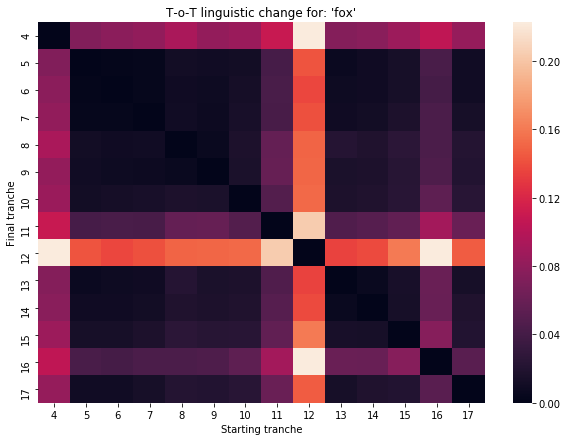

In [41]:
targetWord = 'fox' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting tranche")
ax.set_ylabel("Final tranche")
ax.set_ylabel("Final tranche")
ax.set_title("T-o-T linguistic change for: '{}'".format(targetWord))
plt.show()

In [20]:
reddit_submissions_trump['created_tranche'].value_counts(sort = False)

0        0
1        9
2       64
3      740
4     5724
5     2858
6     3033
7     3410
8     4870
9     3457
10    3357
11    3051
12    3026
13    2729
14    2867
15    3147
16    1809
17    2118
18     797
19    1026
Name: created_tranche, dtype: int64

In [51]:
reddit_submissions_trump2['created_myear'].value_counts(sort = False)

2018-01    1512
2018-02    1469
2018-03    1175
2016-02    1908
2016-03    3378
2016-04    1719
2016-05    1196
2016-06    1305
2016-07    1645
2016-08    1316
2016-09    1457
2016-10    2564
2016-11    2499
2016-12    1820
2017-01    1707
2017-02    1601
2017-03    1615
2017-04    1577
2017-05    1764
2017-06    1202
2017-07    1310
2017-08    1715
2017-09    1249
2017-10    1382
2017-11    1354
2017-12    1463
Freq: M, Name: created_myear, dtype: int64

In [8]:
reddit_submissions_trump2 = reddit_submissions_trump[reddit_submissions_trump['created_utc'].isin(range(1454284800,1522540800))]
reddit_submissions_trump2['created_myear'] = pandas.to_datetime(reddit_submissions_trump2['created_datetime']).dt.to_period('M')

/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
rawEmbeddings2, comparedEmbeddings2 = compareModels(reddit_submissions_trump2, 'created_myear')

military


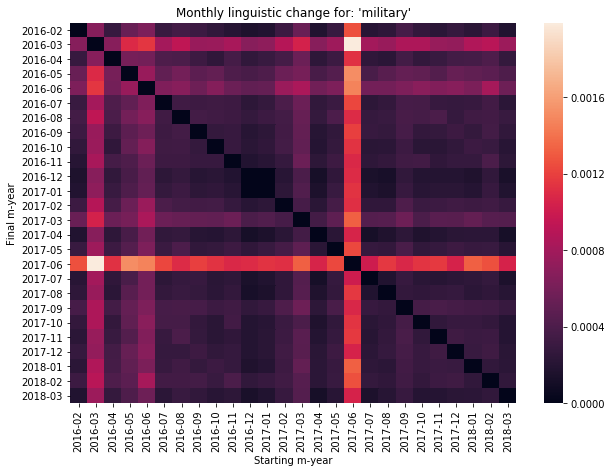

In [63]:
targetWord = 'military' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

email


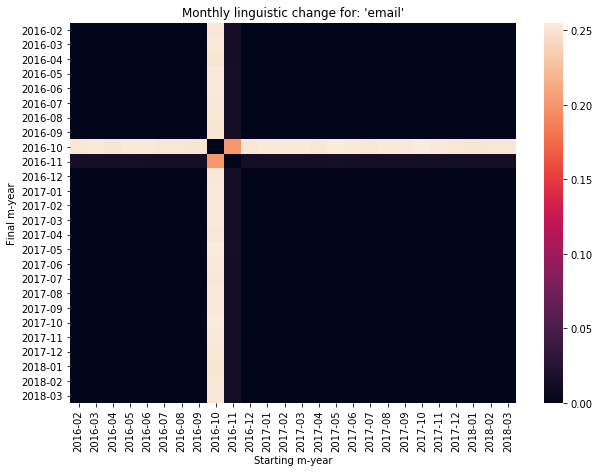

In [78]:
targetWord = 'email' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

white


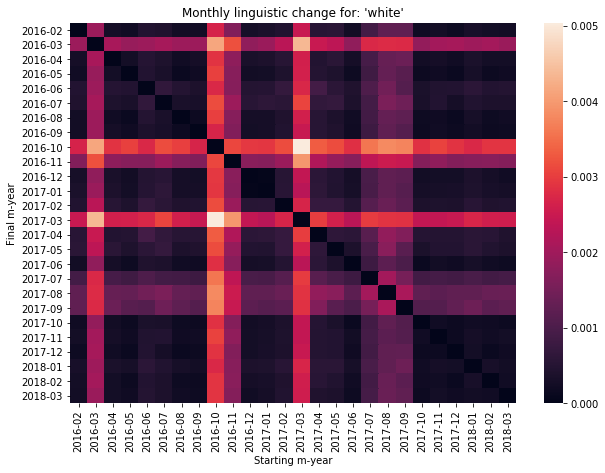

In [80]:
targetWord = 'white' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

hack


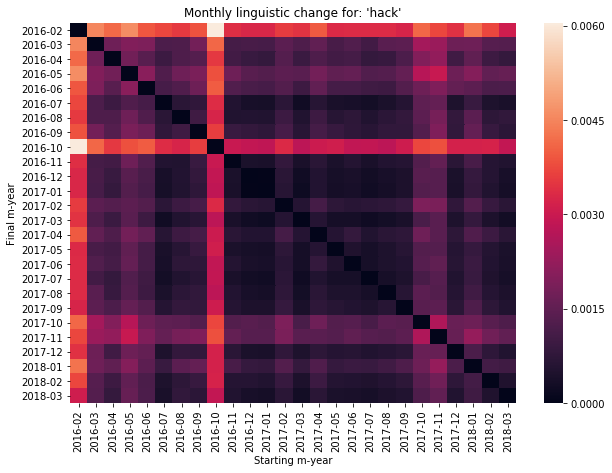

In [83]:
targetWord = 'hack' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

russia


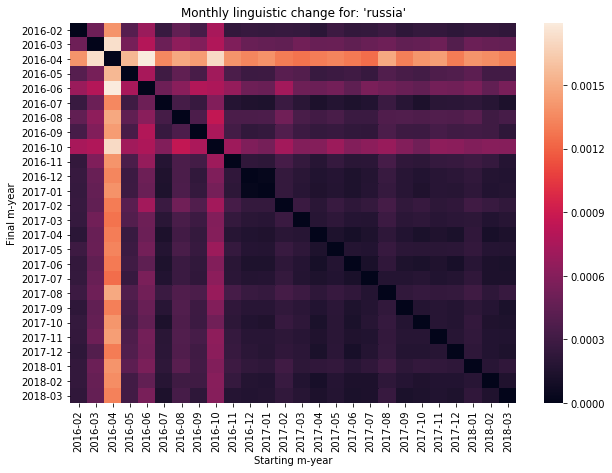

In [84]:
targetWord = 'russia' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

republicans


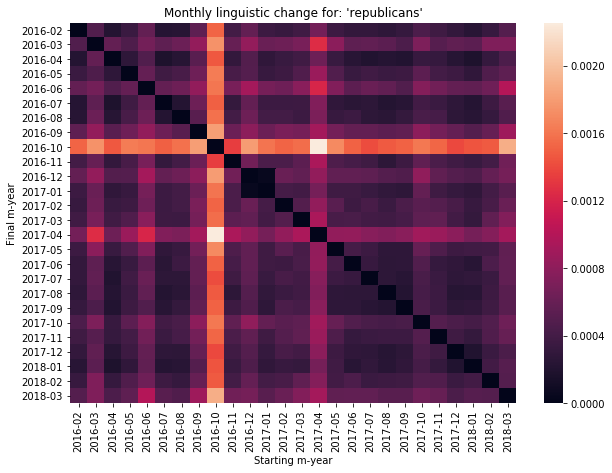

In [103]:
targetWord = 'republicans' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

fbi


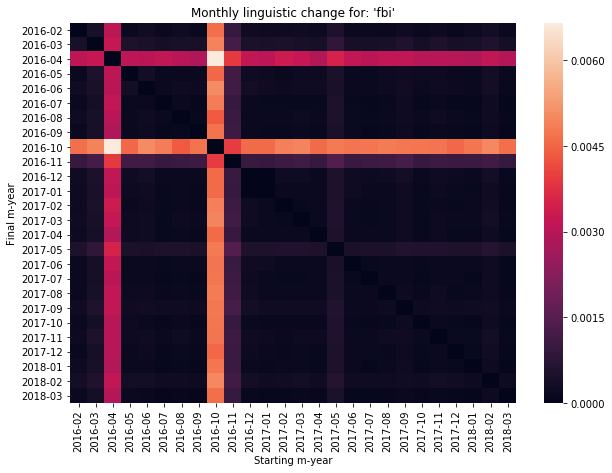

In [88]:
targetWord = 'fbi' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

tweet


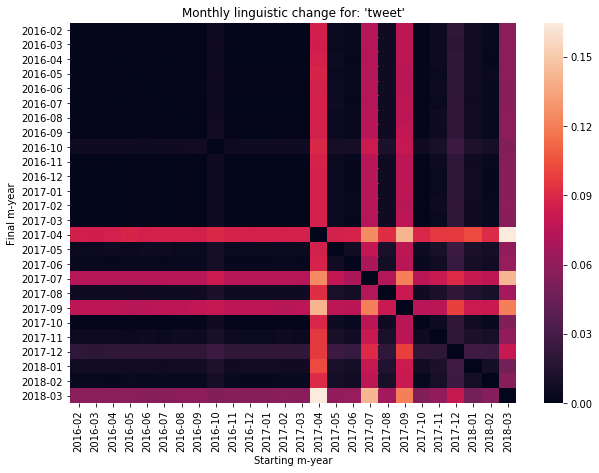

In [115]:
targetWord = 'tweet' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

facebook


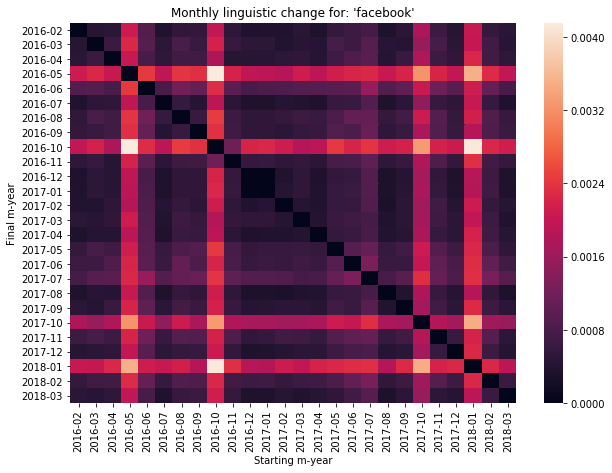

In [116]:
targetWord = 'facebook' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

twitter


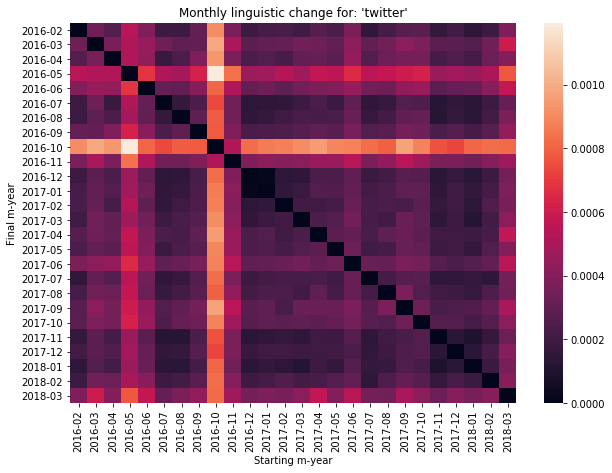

In [117]:
targetWord = 'twitter' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

hack


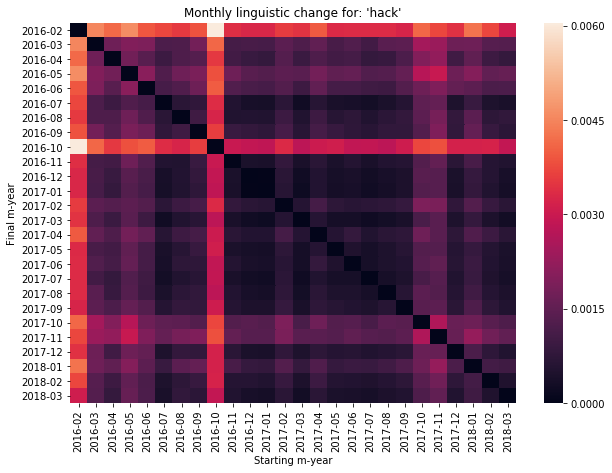

In [119]:
targetWord = 'hack' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

news


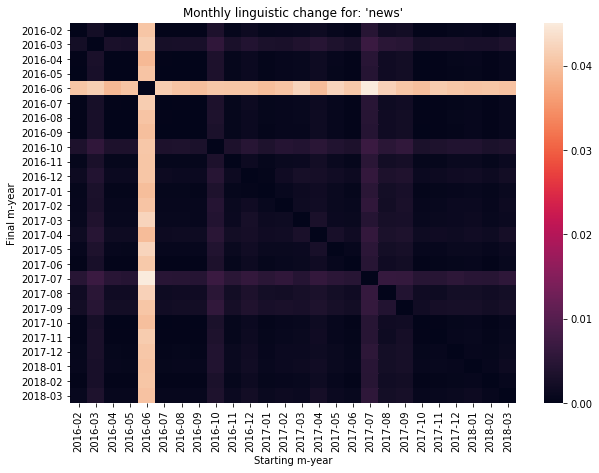

In [10]:
targetWord = 'news' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

fake


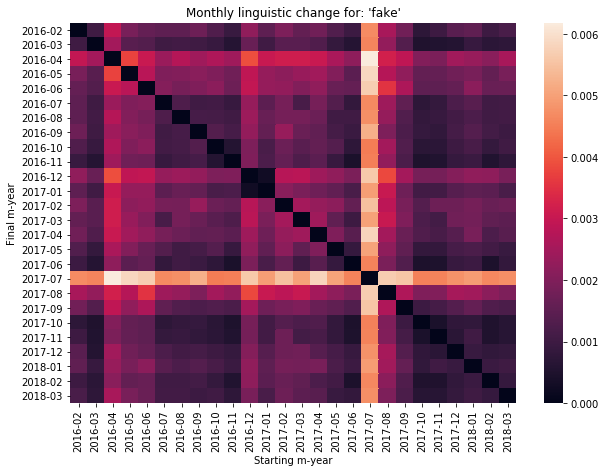

In [24]:
targetWord = 'fake' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

russia


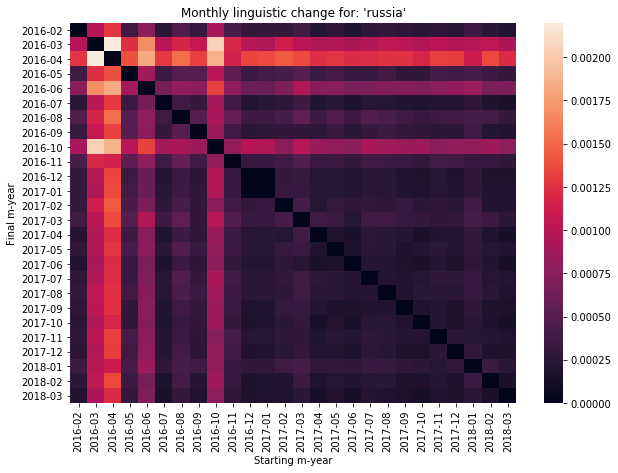

In [15]:
targetWord = 'russia' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

immigrant


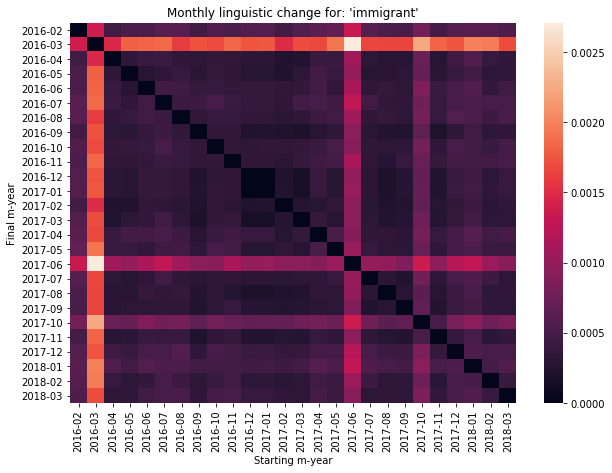

In [25]:
targetWord = 'immigrant' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

immigration


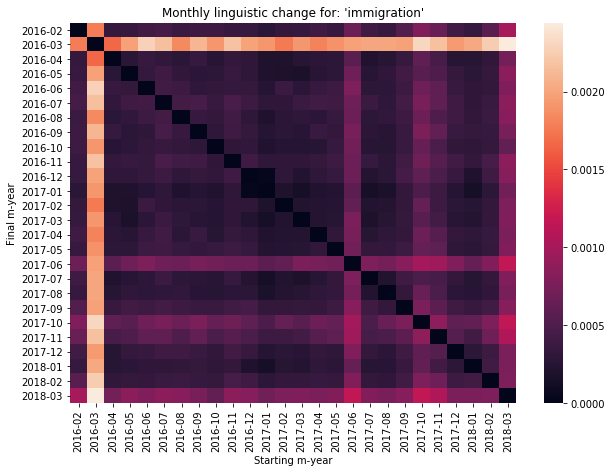

In [52]:
targetWord = 'immigration' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

health


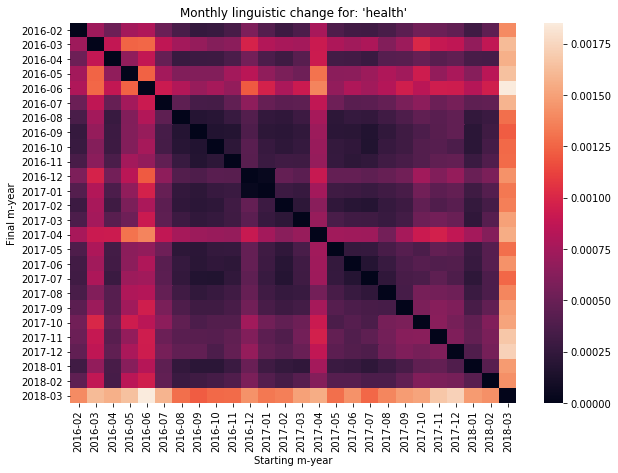

In [50]:
targetWord = 'health' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

trump


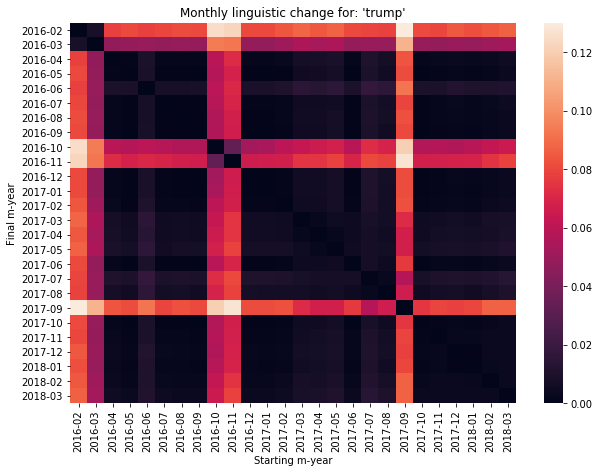

In [51]:
targetWord = 'trump' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

class


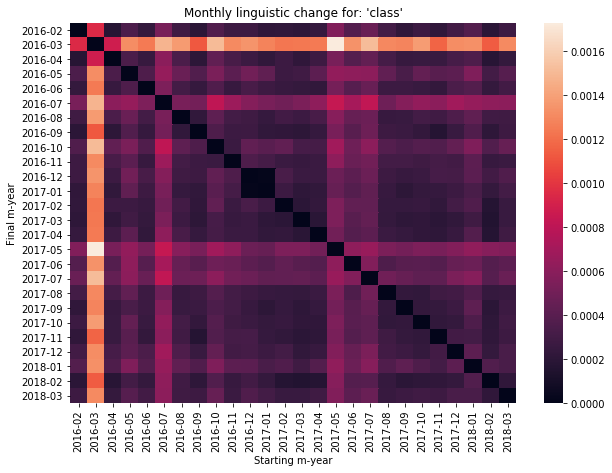

In [59]:
targetWord = 'class' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

In [104]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [107]:
wordDivergences2 = findMostDivergent(comparedEmbeddings2)

Found 924 words to compare


In [108]:
wordDivergences2[:25]

[('trump', 3.6462849974632263),
 ('energy', 1.5242259502410889),
 ('r', 1.4161617755889893),
 ('=', 1.1861382126808167),
 ('the_donald', 1.1294597387313843),
 ('high', 1.0608083605766296),
 ('+', 0.8129616975784302),
 ('donald', 0.37994641065597534),
 ('low', 0.37201088666915894),
 ('tweet', 0.3593115210533142),
 ('watch?v', 0.3535594940185547),
 ('j.', 0.32857269048690796),
 ('/r', 0.3285374641418457),
 ('america', 0.32346367835998535),
 ('maga', 0.3039381504058838),
 ('politic', 0.30357444286346436),
 ('usa', 0.2781744599342346),
 ('email', 0.2737985849380493),
 ('great', 0.25517117977142334),
 ('current', 0.23132556676864624),
 ('president', 0.21925830841064453),
 ('theory', 0.21279025077819824),
 ('wtf', 0.19579297304153442),
 ('supporter', 0.18486595153808594),
 ('vote', 0.16519176959991455)]

In [111]:
wordDivergences2[-10:]

[('hold', 0.004893362522125244),
 ('force', 0.004736363887786865),
 ('use', 0.004646182060241699),
 ('little', 0.00458604097366333),
 ('public', 0.004486501216888428),
 ('end', 0.004378080368041992),
 ('order', 0.004345953464508057),
 ('turn', 0.004045367240905762),
 ('allow', 0.003776073455810547),
 ('base', 0.0030490756034851074)]

vote


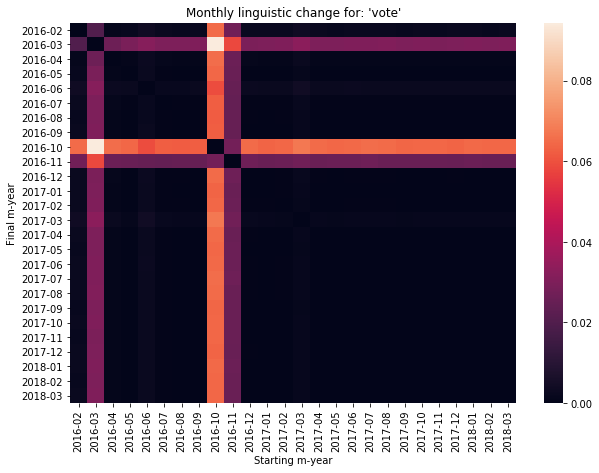

In [125]:
targetWord = wordDivergences2[24][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()